<h2>Define our GMM class</h2>

In [3]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import mode
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
iris = load_iris()
X = iris.data

In [11]:
class GMM:
  def __init__(self, k, max_iters=5):
    self.k=k
    self.max_iters=int(max_iters)
  
  def initialize(self,  X):
    # store the shape of X
    self.shape = X.shape
    self.n, self.m = self.shape
    # initialize the weights assigning to each cluster in k cluster
    self.phi = np.full(shape=self.k, fill_value=1/self.k)
    # initial weights given to each data points 
    self.weights = np.full(shape = self.shape, fill_value=1/self.k)
    # generate random row index
    random_row = np.random.randint(low=0, high=self.n, size=self.k)
    # initialize the mean of each cluster
    self.mu = [X[row_id,:] for row_id in random_row]
    # initialize the covariance matrices of clusters
    self.sigma = [np.cov(X.T) for _ in range(self.k)]
  # E step: update weights and phi holding mu and sigma constant
  
  def e_step(self, X):
    self.weights = self.predict_prob(X)
    self.phi = self.weights.mean(axis=0)
  
  def m_step(self, X):
    for i in range(self.k):
      weight = self.weights[:,[i]]
      total_weight = weight.sum()
      self.mu[i] = (X*weight).sum(axis=0) / total_weight
      self.sigma[i] = np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)
  
  def predict(self,X):
      weights = self.predict_prob(X)
      #datapoint belongs to cluster with maximum probability
      return np.argmax(weights, axis=1)

  def predict_prob(self,X):
      # initialize a matrix containing probability of each datapoint wrt each cluster
      likelihood = np.zeros((self.n, self.k))
      for i in range(self.k):
        distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
        likelihood[:,i] = distribution.pdf(X)
      
      numerator = likelihood * self.phi
      denominator = numerator.sum(axis=1)[:,np.newaxis]
      weights = numerator/denominator
      return weights

  #fit function
  def fit(self, X):
    # initialize weight, phi, mu, sigma of all Gaussians in dataset X
    self.initialize(X)
    plt.figure(figsize=(16, 25))
    for iteration in range(self.max_iters):
      permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
      permuted_prediction = permutation[self.predict(X)]
      print("The accuracy of the permuted prediction against target before iteration ",iteration+1,end="")
      print(": ", np.mean(iris.target==permuted_prediction))
      confusion_matrix(iris.target, permuted_prediction)
      plt.title("Iteration Cluster")
      plt.subplot(5,3,iteration+1)
      clusters=permuted_prediction
      plt.xlabel(iris.feature_names[0])
      plt.ylabel(iris.feature_names[1])
      plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')
      plt.grid()
      plt.tight_layout()
      # E step and M step in EM algorithm
      self.e_step(X)
      self.m_step(X)
    return permuted_prediction
  

In [5]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

<h2>Testing the model on Iris dataset

In [6]:
import pandas as pd
Y = pd.DataFrame(X, columns=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'])
Y.head()

,Sepal length,Sepal width,Petal length,Petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
Y.describe()

,Sepal length,Sepal width,Petal length,Petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


<h2>Visualising the data

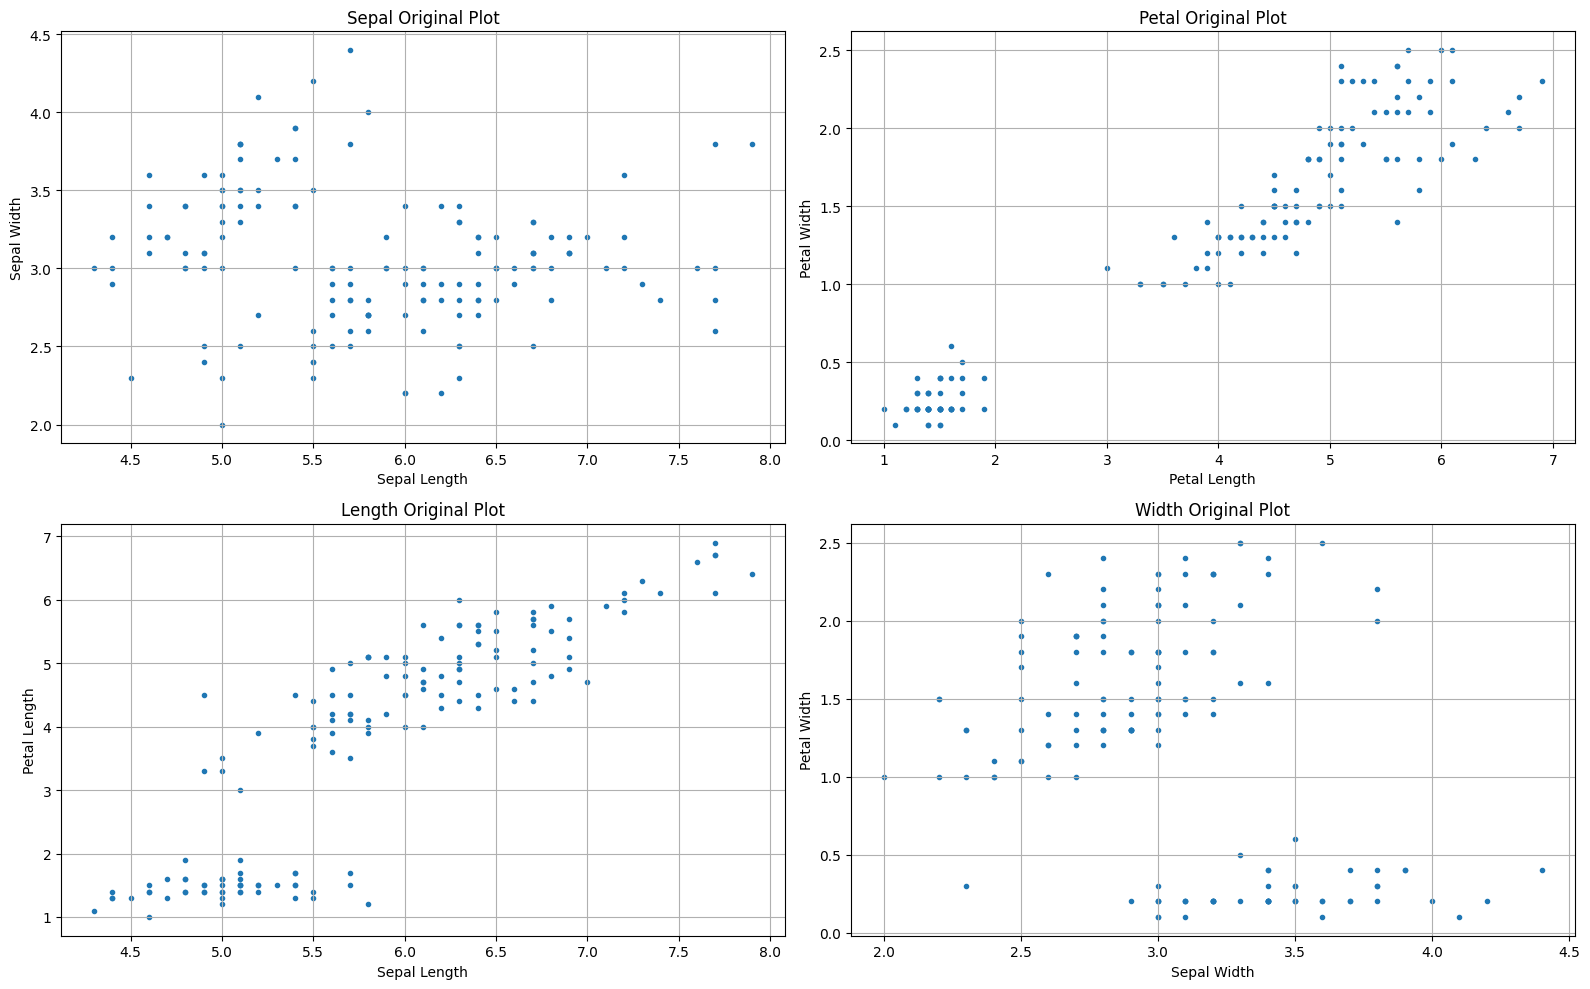

In [8]:
plt.figure(figsize=(16,10))
#scatter the plot of sepal length vs sepal width
plt.subplot(2,2,1)
plt.scatter(list(Y.iloc[:,0]), list(Y.iloc[:,1]), marker='.')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.title("Sepal Original Plot")
plt.grid()
plt.tight_layout()
#scatter the plot of petal length vs petal width
plt.subplot(2,2,2)
plt.scatter(list(Y.iloc[:,2]), list(Y.iloc[:,3]), marker='.')
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Petal Original Plot")
plt.grid()
plt.tight_layout()
#scatter the plot of sepal length vs petal length
plt.subplot(2,2,3)
plt.scatter(list(Y.iloc[:,0]), list(Y.iloc[:,2]), marker='.')
plt.xlabel("Sepal Length")
plt.ylabel("Petal Length")
plt.title("Length Original Plot")
plt.grid()
plt.tight_layout()
#scatter the plot of sepal width vs petal width
plt.subplot(2,2,4)
plt.scatter(list(Y.iloc[:,1]), list(Y.iloc[:,3]), marker='.')
plt.xlabel("Sepal Width")
plt.ylabel("Petal Width")
plt.title("Width Original Plot")
plt.grid()
plt.tight_layout()

<h2>Plotting our predictions

In [14]:
def jitter(x):
  return x + np.random.uniform(low=-0.05, high=0.05, size=x.shape)

def plot_axis_pairs(X, axis_pairs, clusters, classes):
  n_rows = len(axis_pairs) // 2
  n_cols = 2
  plt.figure(figsize=(16,10))
  # iterates through all the plots
  for index, (x_axis, y_axis) in enumerate(axis_pairs):
    plt.subplot(n_rows, n_cols, index+1)
    plt.title("Final cluster")
    plt.xlabel(iris.feature_names[x_axis])
    plt.ylabel(iris.feature_names[y_axis])
    plt.scatter(jitter(X[:, x_axis]), jitter(X[:, y_axis]), c=clusters, cmap = plt.cm.get_cmap('brg'), marker='.')
    plt.grid()
    plt.tight_layout()

<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:62: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,3,iteration+1)
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matpl

The accuracy of the permuted prediction against target before iteration  1:  0.6266666666666667
The accuracy of the permuted prediction against target before iteration  2:  0.68


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')
<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `

The accuracy of the permuted prediction against target before iteration  3:  0.7866666666666666
The accuracy of the permuted prediction against target before iteration  4:  0.8533333333333334


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  5:  0.86


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  6:  0.8733333333333333


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  7:  0.8866666666666667


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  8:  0.9


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  9:  0.9466666666666667


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  10:  0.9733333333333334


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  11:  0.96


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  12:  0.9533333333333334


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  13:  0.9666666666666667


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  14:  0.9666666666666667


<ipython-input-11-41412564e1db>:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  permutation = np.array([mode(iris.target[self.predict(X)==i]).mode.item() for i in range(self.k)])
<ipython-input-11-41412564e1db>:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:,0]), jitter(X[:,1]), c=clusters, cmap=plt.cm.get_cmap('brg'), marker='.')


The accuracy of the permuted prediction against target before iteration  15:  0.9666666666666667


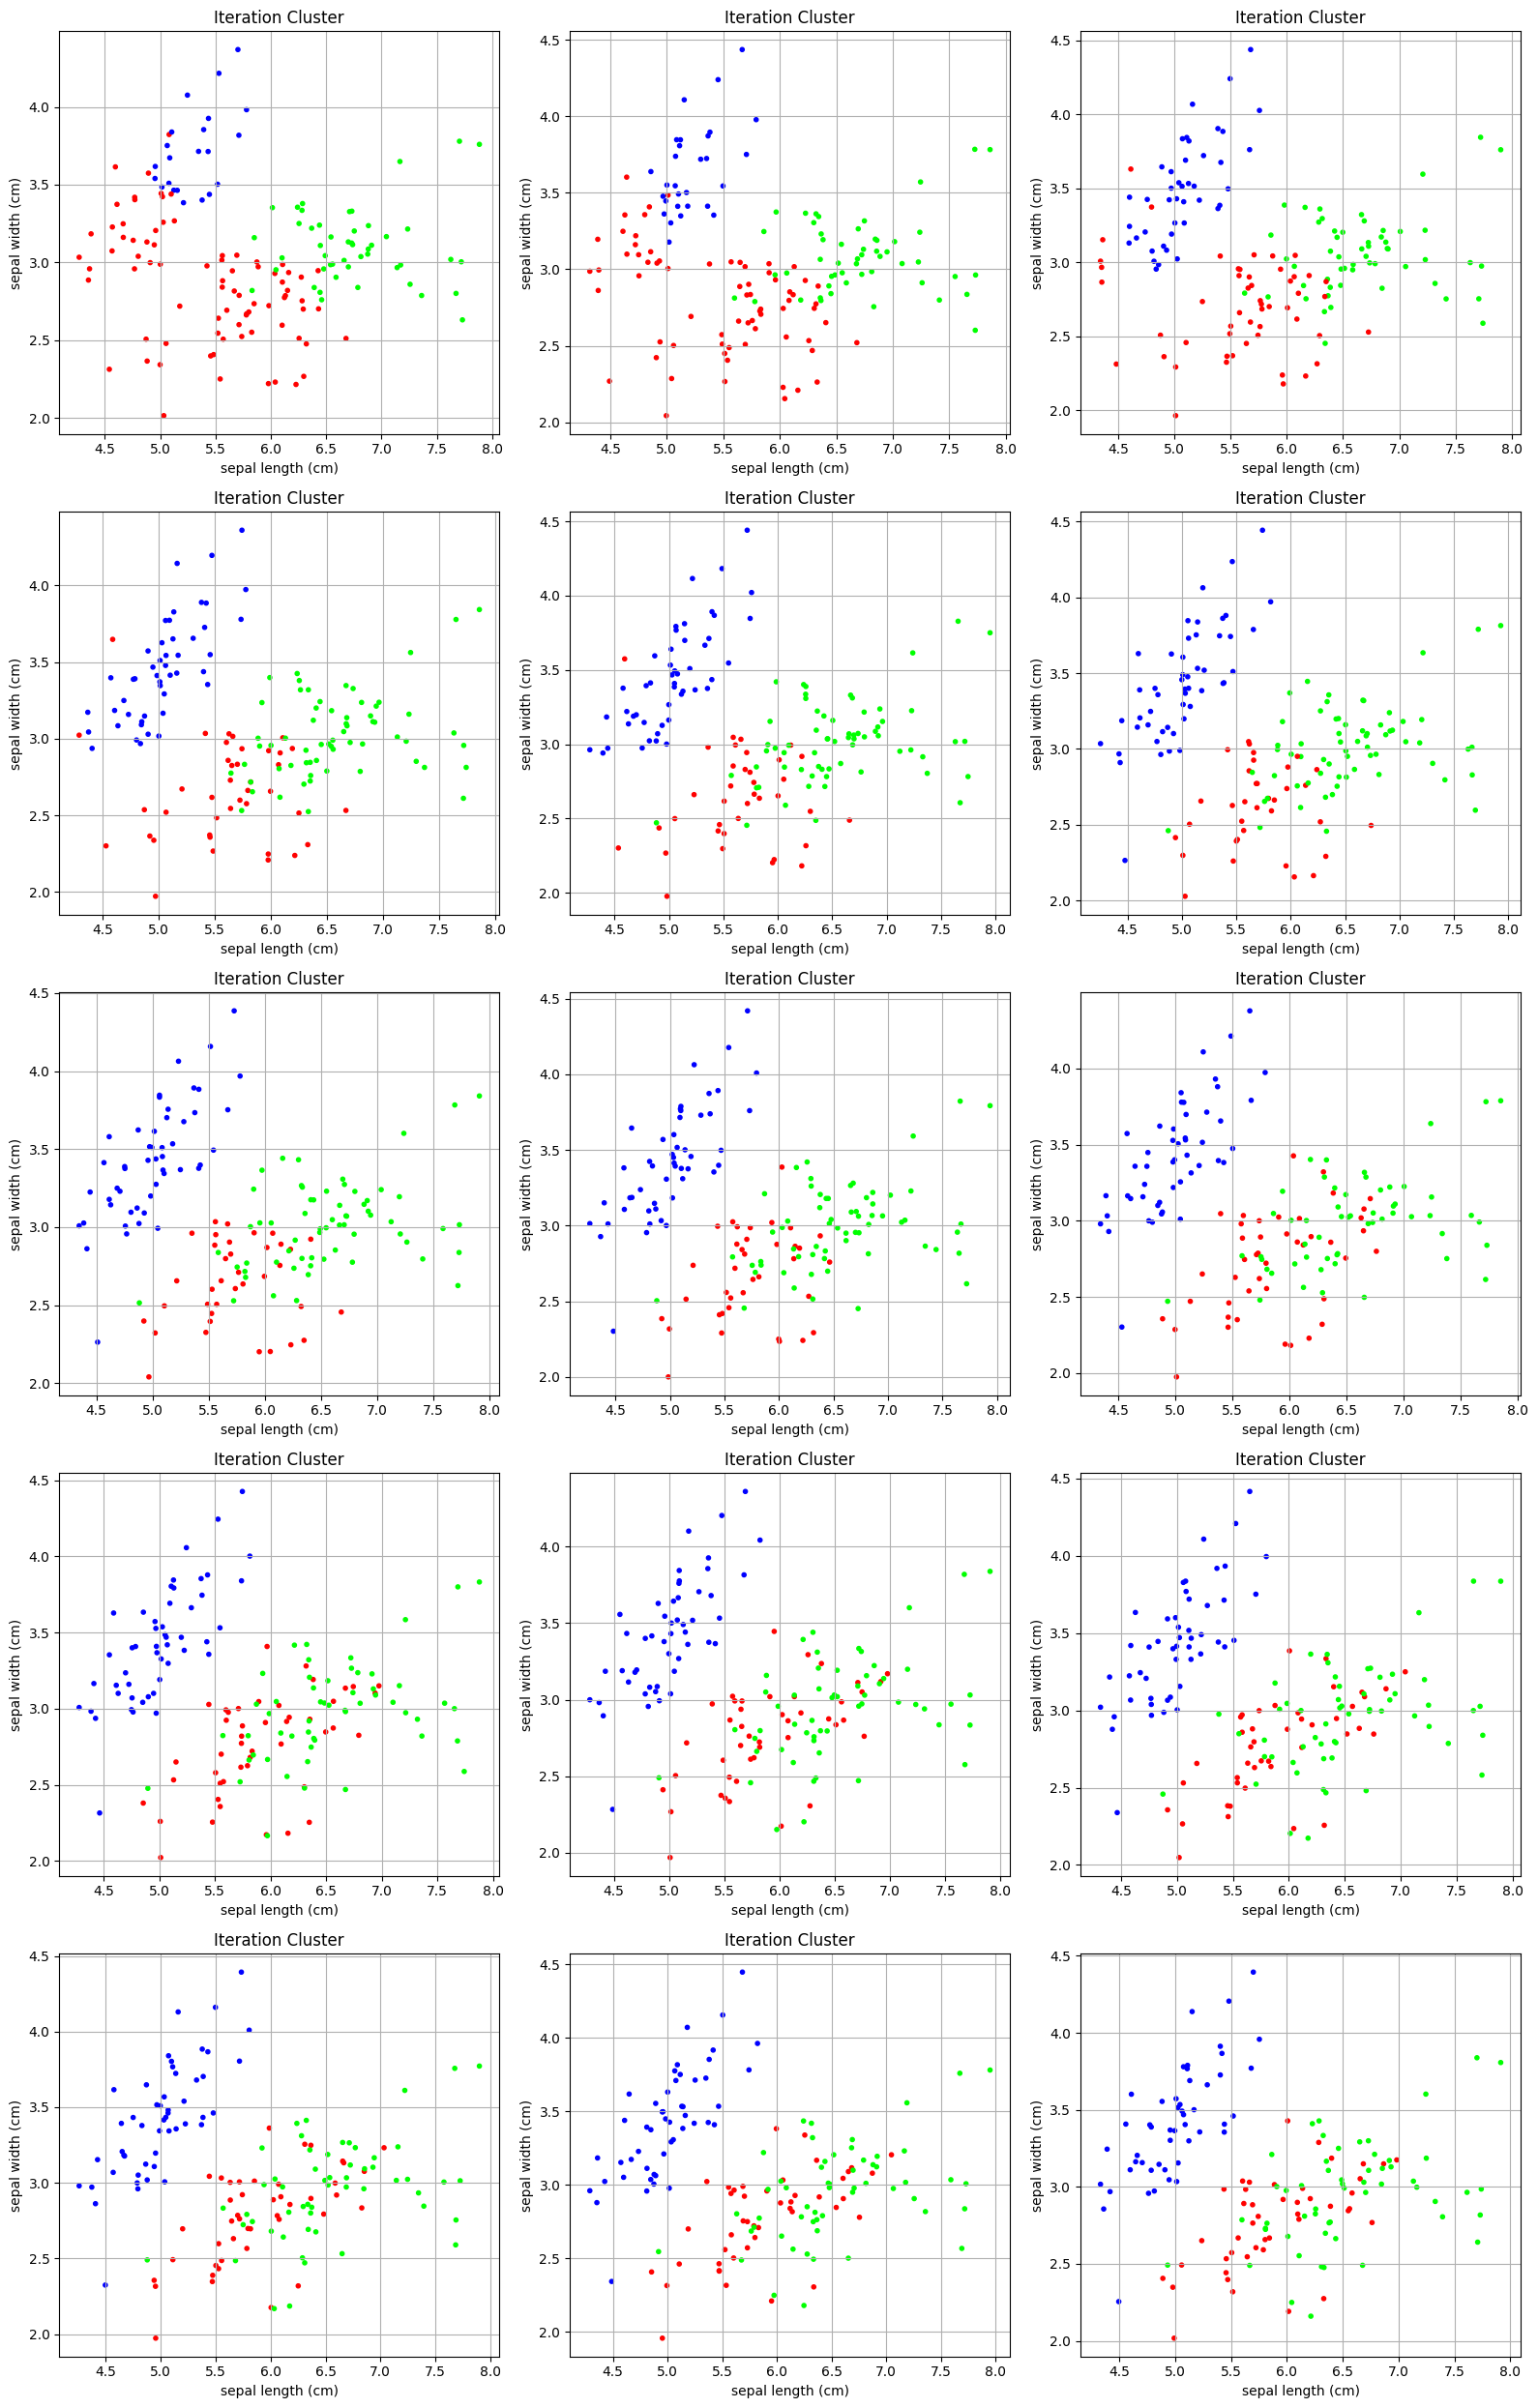

In [12]:
np.random.seed(42)
gmm = GMM(k=3, max_iters=15)
permuted_prediction=gmm.fit(X)

<ipython-input-14-16cffc3ad553>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(jitter(X[:, x_axis]), jitter(X[:, y_axis]), c=clusters, cmap = plt.cm.get_cmap('brg'), marker='.')


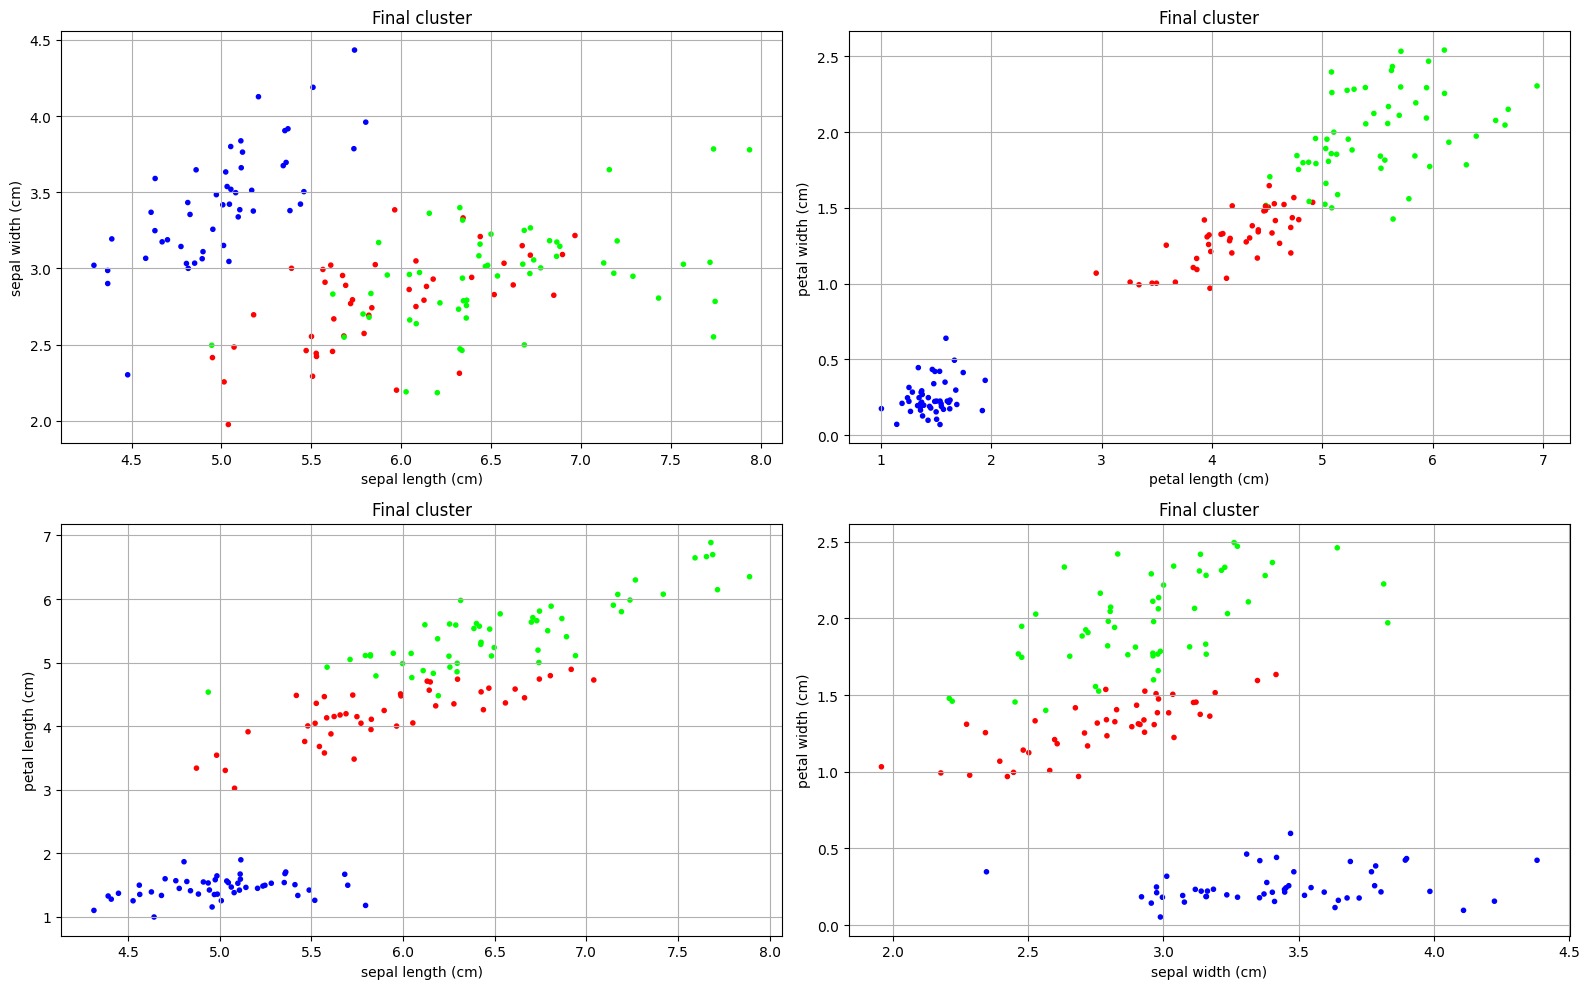

In [15]:
plot_axis_pairs(X=X,axis_pairs=[(0,1), (2,3),(0,2), (1,3)],clusters=permuted_prediction,classes=iris.target)